# The Problem and the Data
X, formerly known as Twitter, is a place where many people tweet about both disasters as well as other things that may sound like disasters out of context.  This project is about determining if a tweet is about a disaster or something else.
The data is a CSV with a few columns: an ID, a keyword, a location, the text, and a target column which is either 0 if the tweet is not about disasters, or a 1 if it is.

# Exploratory Data Analysis
To start, let's load in the data and have a glance at it.

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob # this is a useful library for NLP preprocessing
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [11]:
train = pd.read_csv('nlp-getting-started/train.csv')

train.info()
train.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


We can see that there are a lot of NaN values for keyword and location.  These may confuse the model weights, so I elect to remove them from the training set.

In [12]:
train.drop(columns=['keyword'], inplace=True)
train.drop(columns=['location'], inplace=True)

train.info()
train.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      7613 non-null   int64 
 1   text    7613 non-null   object
 2   target  7613 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 178.6+ KB


,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


## Distribution of Data
Now, lets have a look at if our dataset is skewed one way or another.  We will do this with a simple chart.
As we can see, there are more non disaster tweets than disaster tweets.  We may want to account for this difference depending on initial model performance.

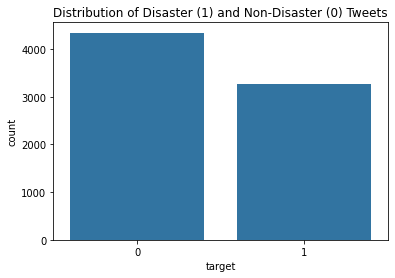

In [14]:
sns.countplot(x='target', data=train)
plt.title('Distribution of Disaster (1) and Non-Disaster (0) Tweets')
plt.show()

### Length Analysis
Lets also look if there is a difference in length between types of tweets.  From this we can see that disaster tweets are typically a little longer than non-disaster tweets.  This may be helpful for the model to know.

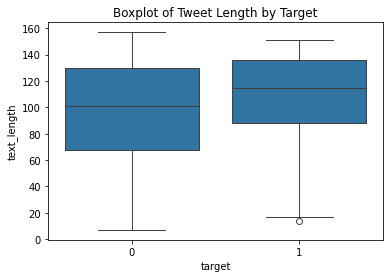

In [15]:
train['text_length'] = train['text'].apply(len)

sns.boxplot(x='target', y='text_length', data=train)
plt.title('Boxplot of Tweet Length by Target')
plt.show()

### Sentiment Analysis in Preprocessing
We can use the handy textblob library to perform sentiment analysis.  One would think that there is more negative sentiment behind disaster tweets, but this is actually not the case.  There is, however, less of a variance.  We can see from the chart below that many disaster tweets trend very close to 0.00 sentiment.  This is interesting and may make sentiment a valuable feature for our model.  

We will also look at subjectivity in the same light.  We can see that sentiment subjectivity is slightly higher for non-disaster tweets.  Since these don't vary that much, we will probably not include this.

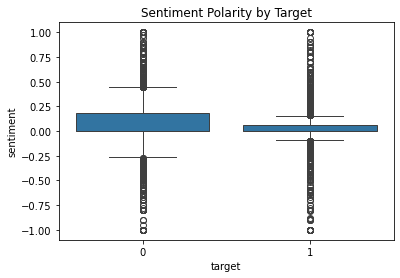

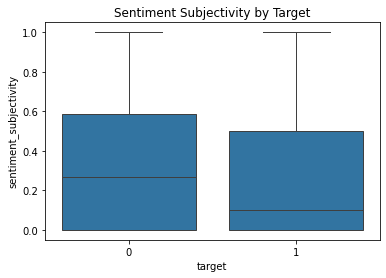

In [20]:

train['sentiment'] = train['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

sns.boxplot(x='target', y='sentiment', data=train)
plt.title('Sentiment Polarity by Target')
plt.show()

train['sentiment_subjectivity'] = train['text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

sns.boxplot(x='target', y='sentiment_subjectivity', data=train)
plt.title('Sentiment Subjectivity by Target')
plt.show()

## Preprocessing
There is a lot we can do in terms of preprocessing.  It is important to keep in mind that as this is a deep learning project, we don't need to worry as much about noise, since neural networks are usually good at handling noise.  We will, however, still be doing a lot of preprocessing.
To simplify the preprocessing process, we will condense many operations into a few functions, and then apply that to the dataframe.

In [23]:
def clean_and_correct_text(text):
    # First, convert text to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    # Also remove mentions and hashtags
    text = re.sub(r'@\w+|#\w+', '', text)
    
    # Remove special characters and numbers, keep only text and spaces
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Finally, Correct spelling using TextBlob
    blob = TextBlob(text)
    corrected_text = str(blob.correct())
    
    return corrected_text

train['cleaned_text'] = train['text'].apply(clean_and_correct_text)

This function takes a while to run!

## Tokenizing the Text
This is an important step.  Cutting edge NLP models such as GPT use tokenizers to better understand text.  We will absolutely be doing the same, and it will probably improve model performance.  We will be using the built in tensorflow/keras tokenizer.

In [29]:
# Initialize the tokenizer
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")  # <OOV> is for out-of-vocab words

# Fit the tokenizer
tokenizer.fit_on_texts(train['cleaned_text'].values)

# Now we will apply the tokenizer to create tokenized_cleaned_text
train['tokenized_cleaned_text'] = tokenizer.texts_to_sequences(train['cleaned_text'].values)

train.info()
train.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      7613 non-null   int64  
 1   text                    7613 non-null   object 
 2   target                  7613 non-null   int64  
 3   text_length             7613 non-null   int64  
 4   sentiment               7613 non-null   float64
 5   sentiment_subjectivity  7613 non-null   float64
 6   cleaned_text            7613 non-null   object 
 7   tokenized_cleaned_text  7613 non-null   object 
dtypes: float64(2), int64(3), object(3)
memory usage: 475.9+ KB


,id,text,target,text_length,sentiment,sentiment_subjectivity,cleaned_text,tokenized_cleaned_text
0,1,Our Deeds are the Reason of this #earthquake M...,1,69,0.000000,0.000000,our deeds are the reason of this may allah fo...,"[107, 4006, 22, 2, 788, 6, 19, 74, 2262, 3212,..."
1,4,Forest fire near La Ronge Sask. Canada,1,38,0.100000,0.400000,forest fire near la range ask canada,"[185, 48, 206, 614, 2263, 1333, 1247]"
2,5,All residents asked to 'shelter in place' are ...,1,133,-0.018750,0.387500,all residents asked to shelter in place are be...,"[36, 1649, 1334, 5, 1976, 3, 637, 22, 121, 551..."
3,6,"13,000 people receive #wildfires evacuation or...",1,65,0.000000,0.000000,people receive evacuation orders in california,"[64, 4007, 229, 1335, 3, 97]"
4,7,Just got sent this photo from Ruby #Alaska as ...,1,88,0.000000,0.000000,just got sent this photo from ruby as smoke f...,"[29, 84, 1089, 19, 186, 20, 5517, 28, 237, 20,..."
5,8,#RockyFire Update => California Hwy. 20 closed...,1,110,-0.112500,0.237500,update california why closed in both direct...,"[409, 97, 89, 789, 3, 505, 5518, 246, 5, 1090,..."
6,10,#flood #disaster Heavy rain causes flash flood...,1,95,-0.200000,0.500000,heavy rain causes flash flooding of streets ...,"[856, 315, 1163, 790, 277, 6, 1651, 3, 3213, 1..."
7,13,I'm on top of the hill and I can see a fire in...,1,59,0.500000,0.500000,in on top of the hill and i can see a fire in ...,"[3, 11, 214, 6, 2, 1798, 7, 8, 38, 99, 4, 48, ..."
8,14,There's an emergency evacuation happening now ...,1,79,0.000000,0.000000,there an emergency evacuation happening now in...,"[56, 46, 71, 229, 1164, 51, 3, 2, 563, 821, 2,..."
9,15,I'm afraid that the tornado is coming to our a...,1,52,-0.600000,0.900000,in afraid that the tornado is coming to our area,"[3, 2265, 15, 2, 476, 9, 88, 5, 107, 293]"


# Model Architecture
There are numerous considerations to make with respect to model architecture.  There are a few components, like the word embedding that need to be sorted out first.  TF-IDF is an ok option, but it seems to have been superseeded by Word2Vec and GloVe.  Since we have a wide variety of words, we would ideally go with GloVe, which seems to be a common choice when this is the case.  This, however, is not feasible to do on my hardware, so I will be going with the built-in tensorflow embedding layer.  Note that the tokenized text will be fed into the embedder.

As for the model itself, we are using an RNN due to the school's requirements.  LSTM layers will be used as they help overcome the limitations of basic RNNs.

Now, let's define the actual model.

In [32]:
vocab_size = 20000 # I believe this must be the same size as the tokenizer vocab. 
embedding_dim = 100

model = Sequential([
    Embedding(
        input_dim=vocab_size, 
        output_dim=embedding_dim,
        trainable=True
    ),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid') # output layer
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         2000000   
                                                                 
 bidirectional (Bidirection  (None, None, 128)         84480     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2129921 (8.13 MB)
Trainable params: 2129

# Results and Analysis
With the model compiled, we will now train it.  Training will involve using the train.csv, so we do not need to split any data.  We also will not be validating yet, as we will use the test dataset with Kaggle for that.

Note that in order to get this to fit with the model, we have to make a few adjustments below.  These probably should've been done in preprocessing, and in the future will be.  Basically, they need to be extracted from the data frame, and padded so that they are all the same size.

In [37]:
sequences = train['tokenized_cleaned_text'].tolist()
x_padded = pad_sequences(sequences, maxlen=240, padding='post')
X = np.array(x_padded)
y = train['target'].values


In [38]:
trained_model = model.fit(X, y, epochs=1, batch_size=32)



238/238 [==============================] - 26s 94ms/step - loss: 0.5248 - accuracy: 0.7370


We have completed one epoch of training.  Since it went quickly, we will now begin the process of training for many epochs, and then plotting performance.

In [41]:
trained_model = model.fit(X, y, epochs=30, batch_size=32)

Epoch 1/30
238/238 [==============================] - 23s 97ms/step - loss: 0.3217 - accuracy: 0.8709
Epoch 2/30
238/238 [==============================] - 23s 98ms/step - loss: 0.2110 - accuracy: 0.9229
Epoch 3/30
238/238 [==============================] - 23s 96ms/step - loss: 0.1429 - accuracy: 0.9513
Epoch 4/30
238/238 [==============================] - 23s 97ms/step - loss: 0.1000 - accuracy: 0.9606
Epoch 5/30
238/238 [==============================] - 23s 98ms/step - loss: 0.0788 - accuracy: 0.9645
Epoch 6/30
238/238 [==============================] - 23s 99ms/step - loss: 0.0642 - accuracy: 0.9677
Epoch 7/30
238/238 [==============================] - 24s 102ms/step - loss: 0.0693 - accuracy: 0.9666
Epoch 8/30
238/238 [==============================] - 24s 103ms/step - loss: 0.0577 - accuracy: 0.9737
Epoch 9/30
238/238 [==============================] - 23s 98ms/step - loss: 0.0523 - accuracy: 0.9754
Epoch 10/30
238/238 [==============================] - 24s 100ms/step - loss: 0.

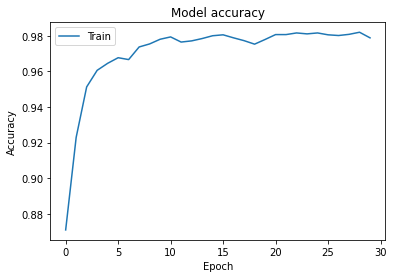

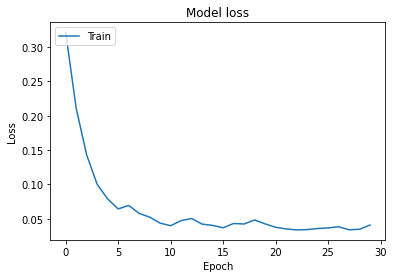

In [42]:
plt.plot(trained_model.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

# Plot training
plt.plot(trained_model.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

## Model Testing
We can see that the model performed nicely on the test data, reaching around 98% accuracy.  Now that the model is ready for testing, we will load in and preprocess the test set.

In [44]:
test = pd.read_csv('nlp-getting-started/test.csv')
test.drop(columns=['keyword', 'location'], inplace=True)
test.info()
test.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      3263 non-null   int64 
 1   text    3263 non-null   object
dtypes: int64(1), object(1)
memory usage: 51.1+ KB


,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."


Now, clean the test data.  The clean function is once again, very slow.

In [45]:
test['cleaned_text'] = test['text'].apply(clean_and_correct_text)

Now, tokenize and pad the test data.

In [47]:
test['tokenized_cleaned_text'] = tokenizer.texts_to_sequences(test['cleaned_text'].values)

sequences = test['tokenized_cleaned_text'].tolist()
x_padded = pad_sequences(sequences, maxlen=240, padding='post')
X = np.array(x_padded)

test.info()
test.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   id                      3263 non-null   int64 
 1   text                    3263 non-null   object
 2   cleaned_text            3263 non-null   object
 3   tokenized_cleaned_text  3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


,id,text,cleaned_text,tokenized_cleaned_text
0,0,Just happened a terrible car crash,just happened a terrible car crash,"[29, 863, 4, 1814, 123, 95]"
1,2,"Heard about #earthquake is different cities, s...",heard about is different cities stay safe eve...,"[431, 57, 9, 1146, 1729, 577, 1225, 210]"
2,3,"there is a forest fire at spot pond, geese are...",there is a forest fire at spot pond geese are ...,"[56, 9, 4, 185, 48, 18, 553, 3200, 1, 22, 4334..."
3,9,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting,"[532, 3475]"
4,11,Typhoon Soudelor kills 28 in China and Taiwan,typhoid soudelor kills in china and taiwan,"[539, 749, 453, 3, 385, 7, 1322]"
5,12,We're shaking...It's an earthquake,were shakingits an earthquake,"[69, 1, 46, 560]"
6,21,They'd probably still show more life than Arse...,they probably still show more life than arsena...,"[58, 746, 83, 417, 55, 137, 72, 3514, 127, 145..."
7,22,Hey! How are you?,hey how are you,"[709, 63, 22, 12]"
8,27,What a nice hat?,what a nice hat,"[52, 4, 992, 785]"
9,29,Fuck off!,fuck off,"[358, 91]"


And finally, generate our predictions for submission to Kaggle.

In [48]:
predictions = model.predict(X)
binary_predictions = [1 if x > 0.5 else 0 for x in predictions.flatten()] # do this to make the outputs 0 or 1, instead of decimals.

submission_df = pd.DataFrame({'id': test['id'], 'target': binary_predictions})
submission_file_path = "submission_1.csv"
submission_df.to_csv(submission_file_path, index=False)

102/102 [==============================] - 3s 24ms/step


# Conclusion
After submitting my predictions to Kaggle, my score was much lower than my training accuracy.  My test accuracy was ~0.72.  This is not great, but sufficient for the assignment so I will move on.  Potentially, my model was overfitted because I ran so many epochs where it had leveled out.  I would be curious to see if there was a significant improvement for any of my earlier epoch models.

I had expected that my effort on tokenizing and embedding would do me well.  It probably helped, but I did not test as well as I figured.  Perhaps if I had used a better embedding such as GloVe, it would've performed better.

# References

Dayal, D. (2020, October 27). Unsupervised NLP : Methods and intuitions behind working with unstructured texts. Medium. https://towardsdatascience.com/unsupervised-nlp-methods-and-intuitions-behind-working-with-unstructured-texts-b84aa4d286da 

Garg, V. (2018). Supervising unsupervised learning - MIT. MIT.edu. https://www.mit.edu/~vgarg/neurips2018sup.pdf 

OpenAI. (2018). Improving language understanding with unsupervised learning. https://openai.com/research/language-unsupervised 

Vlachos, A. (2011). Evaluating unsupervised learning for natural language - University of Wisconsin-Madison. https://aclanthology.org/W11-2205.pdf 